In [49]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join as oj
import sys
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
sys.path.append('..')
import src.transforms
import src.viz as viz
from src.config import DIR_IMAGENET_DATA
import foolbox

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load data + models

In [48]:
device = 'cuda'

# load models
m1 = models.alexnet(pretrained=True).eval().to(device)
m2 = models.resnet18(pretrained=True).eval().to(device)

# load data
dset_name = 'val/val' # train or val/val
dset_val = dset.ImageFolder(oj(DIR_IMAGENET_DATA, dset_name), 
                            transforms.Compose([transforms.Resize(256),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor()]))

# generate an adv example

In [65]:
# get point
im_num = 3
im_np, im_torch = src.transforms.get_im(dset_val, im_num)
lab = dset_val[im_num][1]

# preds
preds = m1(im_torch.to(device))
topk, indices = torch.topk(preds, 5)
print('pred class', indices, 'lab', dset_val[im_num][1])

pred class tensor([[  0, 389, 395,  36, 955]], device='cuda:0') lab 0


In [90]:
x = im_torch.to(device)
fmodel = foolbox.models.PyTorchModel(m1, 
                                     bounds=(-5, 5), 
                                     num_classes=1000)
attack = foolbox.attacks.FGSM(fmodel)
x_adv = attack(viz.detach(x).squeeze(), lab)
print('orig label', lab, 'orig pred', m1(x).softmax(dim=1).argmax().item())
print('adv pred', np.argmax(fmodel.predictions(x_adv)))


orig label 0 orig pred 0
adv pred 389


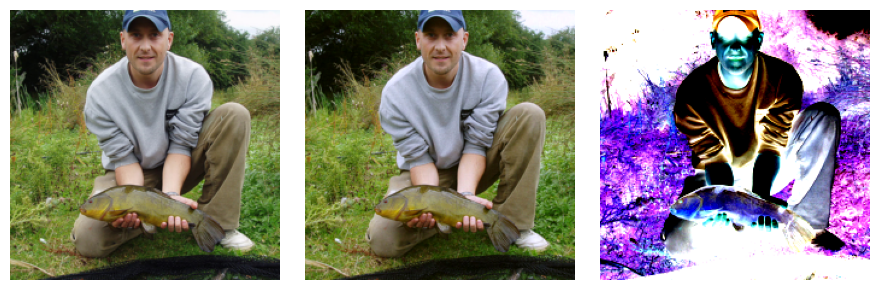

In [91]:
x_adv_np = x_adv.transpose((1, 2, 0))
src.viz.plot_row([im_np, src.transforms.unnormalize(x_adv_np), x_adv_np - x_np])
plt.show()

# benchmark adv predictions

In [ ]:
n = 100

# set up attack
fmodel = foolbox.models.PyTorchModel(m1, 
                                 bounds=(0, 1), 
                                 num_classes=1000)
attack = foolbox.attacks.FGSM(fmodel)

# get preds
preds1 = np.zeros((n, 1000))
preds2 = np.zeros((n, 1000))
for i in tqdm(range(n)):
#     x = torch.randn(1, 3, 224, 224).to(device)
    _, x = src.transforms.get_im(dset_val, i)
    x = (x - x.min()) / (x.max() - x.min())
    lab = dset_val[i][1]

    x_adv = attack(x.detach().cpu().numpy().squeeze(), lab)
    x.data = torch.Tensor(x_adv).unsqueeze(0).to(device)
    
    pred1 = m1(x).detach().cpu()
    pred2 = m2(x).detach().cpu()
    preds1[i] = pred1.flatten()
    preds2[i] = pred2.flatten()

  0%|          | 0/100 [00:00<?, ?it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
 43%|████▎     | 43/100 [00:04<00:05, 10.59it/s]